In [1]:
import pandas as pd
import gc
import time
import numpy as np
import pandas as pd
#load data
def load_data(path_data):
    priors = pd.read_csv(path_data +'\order_products__prior\order_products__prior.csv', 
                     dtype={
                            'order_id': np.int32,
                            'product_id': np.uint16,
                            'add_to_cart_order': np.int16,
                            'reordered': np.int8})
    train = pd.read_csv(path_data +'\order_products__train\order_products__train.csv', 
                    dtype={
                            'order_id': np.int32,
                            'product_id': np.uint16,
                            'add_to_cart_order': np.int16,
                            'reordered': np.int8})
    '''
    --------------------------------order--------------------------------
    * This file tells us which set (prior, train, test) an order belongs
    * Unique in order_id
    * order_id in train, prior, test has no intersection
    * this is the #order_number order of this user
    '''
    orders = pd.read_csv(path_data +'\orders\orders.csv', 
                         dtype={
                                'order_id': np.int32,
                                'user_id': np.int64,
                                'eval_set': 'str',
                                'order_number': np.int16,
                                'order_dow': np.int8,
                                'order_hour_of_day': np.int8,
                                'days_since_prior_order': np.float32})

    #  order in prior, train, test has no duplicate
    #  order_ids_pri = priors.order_id.unique()
    #  order_ids_trn = train.order_id.unique()
    #  order_ids_tst = orders[orders.eval_set == 'test']['order_id'].unique()
    #  print(set(order_ids_pri).intersection(set(order_ids_trn)))
    #  print(set(order_ids_pri).intersection(set(order_ids_tst)))
    #  print(set(order_ids_trn).intersection(set(order_ids_tst)))

    '''
    --------------------------------product--------------------------------
    * Unique in product_id
    '''
    products = pd.read_csv(path_data +'\products\products.csv')
    aisles = pd.read_csv(path_data + "//aisles//aisles.csv")
    departments = pd.read_csv(path_data + "\departments\departments.csv")
    sample_submission = pd.read_csv(path_data + "\sample_submission\sample_submission.csv")

    return priors, train, orders, products,aisles,  departments, sample_submission

def ka_add_groupby_features_n_vs_1(df, group_columns_list, target_columns_list, methods_list, keep_only_stats=True, verbose=1):
    grouped_name = ''.join(group_columns_list)
    target_name = ''.join(target_columns_list)
    combine_name = [[grouped_name] + [method_name] + [target_name] for method_name in methods_list]
    df_new = df.copy()
    grouped = df_new.groupby(group_columns_list)
    the_stats = grouped[target_name].agg(methods_list).reset_index()
    the_stats.columns = [grouped_name] + ['_%s_%s_by_%s' % (grouped_name, method_name, target_name)for (grouped_name, method_name, target_name) in combine_name]
    if keep_only_stats:
        return the_stats
    else:
        df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')
    return df_new


In [2]:
path_data = r'c:\Users\i7546\Desktop\BG\project'
priors, train, orders, products, aisles, departments, sample_submission = load_data(path_data)


In [3]:
"===================products============================"
# Products information ----------------------------------------------------------------
# add order information to priors set
priors_orders_detail = orders.merge(right=priors, how='inner', on='order_id')

# create new variables
# _user_buy_product_times: 
priors_orders_detail.loc[:,'_user_buy_product_times'] = priors_orders_detail.groupby(['user_id', 'product_id']).cumcount() + 1
# _prod_tot_cnts: The total number of times the product is purchased, indicating the degree of being liked
# _reorder_tot_cnts_of_this_prod: The total number of times this item was re purchased
# _prod_order_once: The total number of times the product was purchased once
# _prod_order_more_than_once: The total number of times the commodity is purchased more than once

prd=priors_orders_detail.copy().groupby(['product_id']).agg(_prod_tot_cnts=('user_id','count'),_prod_reorder_tot_cnts=('reordered','sum'),_prod_buy_first_time_total_cnt=('_user_buy_product_times',lambda x: sum(x==1)),_prod_buy_second_time_total_cnt=('_user_buy_product_times',lambda x: sum(x==2)))

# _prod_reorder_prob: 
# _prod_reorder_ratio: Commodity repurchase rate
prd['_prod_reorder_prob'] = prd._prod_buy_second_time_total_cnt / prd._prod_buy_first_time_total_cnt
prd['_prod_reorder_ratio'] = prd._prod_reorder_tot_cnts / prd._prod_tot_cnts
prd['_prod_reorder_times'] = 1 + prd._prod_reorder_tot_cnts / prd._prod_buy_first_time_total_cnt


In [4]:
"=======User Part========================================================"
# _user_total_orders: Total orders of users
# Other statistical indicators can be considered++++++++++++++++++++++++++
# _user_sum_days_since_prior_order: Time since last purchase (sum)
# _user_mean_days_since_prior_order: Time since last purchase (mean)

users=orders[orders.eval_set == 'prior'].copy().groupby(['user_id']).agg(_user_total_orders=('order_number','max'),_user_sum_days_since_prior_order=('days_since_prior_order','sum'),_user_mean_days_since_prior_order=('days_since_prior_order','mean'))

# _user_reorder_ratio: 
# _user_total_products: 
# _user_distinct_products: 
data_new3=priors_orders_detail.copy()
grouped3=data_new3.groupby(['user_id'])
us =grouped3.agg(_user_reorder_ratio=('reordered',lambda x: sum(priors_orders_detail.loc[x.index,'reordered']==1)/sum(priors_orders_detail.loc[x.index,'order_number']>1)),_user_total_products=('product_id','count'),_user_distinct_products=('product_id',lambda x: x.nunique()))

users = pd.merge(users,us,on='user_id',how='inner')

# Average number of items per order
# The maximum number of items in each order and the minimum number of items
users['_user_average_basket'] = users._user_total_products / users._user_total_orders

us = orders[orders.eval_set != "prior"][['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]
us.rename(index=str, columns={'days_since_prior_order': 'time_since_last_order'}, inplace=True)

users = pd.merge(users,us,on='user_id',how='inner')

In [5]:
"===================Database Part¶======================================================"
# _up_order_count: 
# _up_first_order_number: 
# _up_last_order_number: 
# _up_average_cart_position: 
data_new4=priors_orders_detail.copy()
grouped4=data_new4.groupby(['user_id', 'product_id'])
data=grouped4.agg(_up_order_count=('order_number','count'),_up_first_order_number=('order_number','min'),_up_last_order_number=('order_number','max'),_up_average_cart_position=('add_to_cart_order','mean'))


In [6]:
users.set_index('user_id', inplace=True)
data=data.join(prd,on='product_id',how='left')

In [7]:
data=data.join(users,on='user_id',how='left')#Product user data is merged with product and user characteristics.

In [8]:
data['_up_order_rate'] = data._up_order_count / data._user_total_orders
data['_up_order_since_last_order'] = data._user_total_orders - data._up_last_order_number
data['_up_order_rate_since_first_order'] = data._up_order_count / (data._user_total_orders - data._up_first_order_number + 1)

# add user_id to train set
train = train.merge(right=orders[['order_id', 'user_id']], how='left', on='order_id')
data = data.merge(train[['user_id', 'product_id', 'reordered']], on=['user_id', 'product_id'], how='left')

# release Memory
# del train, prd, users
# gc.collect()
# release Memory
del priors_orders_detail, orders
gc.collect()

0

In [9]:
data.to_csv('data.txt')

In [10]:
import os
import datetime
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
os.chdir(r'C:\Users\i7546\Desktop\BG\project')
data=pd.read_csv('data.txt')
train = data.loc[data.eval_set == "train",:]
train.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1, inplace=True)
train.loc[:, 'reordered'] = train.reordered.fillna(0)

X_train, X_val, y_train, y_val = train_test_split(train.drop('reordered', axis=1), train.reordered,test_size=0.9, random_state=42)

F:\Anaconda\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
F:\Anaconda\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


[0]	train-logloss:0.62563
[10]	train-logloss:0.33537
[20]	train-logloss:0.26820
[30]	train-logloss:0.25066
[40]	train-logloss:0.24579
[50]	train-logloss:0.24419
[60]	train-logloss:0.24345
[70]	train-logloss:0.24293
[79]	train-logloss:0.24254
spendt time :30(s)


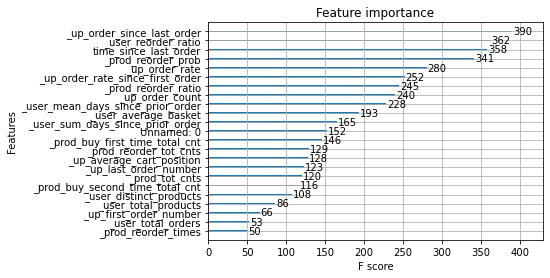

In [11]:
import xgboost 

#train
d_train = xgboost.DMatrix(X_train, y_train)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}

watchlist= [(d_train, "train")]
xgb_start=datetime.now()
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=80, evals=watchlist, verbose_eval=10)
xgb_end=datetime.now()
print('spendt time :'+ str((xgb_end-xgb_start).seconds)+'(s)')
xgboost.plot_importance(bst)

''' train result:
[0]     train-logloss:0.625642
[10]    train-logloss:0.335753
[20]    train-logloss:0.269213
[30]    train-logloss:0.252115
[40]    train-logloss:0.247442
[50]    train-logloss:0.245712
[60]    train-logloss:0.244735
[70]    train-logloss:0.243973
[79]    train-logloss:0.243472
spendt time :41(s)
'''

#predict 
pre_data = xgboost.DMatrix(X_val, y_val)
predict=bst.predict(pre_data)
X_val['reorder']=y_val
X_val['pre']=predict


precision=float(len(X_val[(X_val['pre']>0.5) & (X_val['reorder']==1)]))/\
          float(len(X_val[X_val['pre']>0.5]))   # predict score>0.5 and lables=1 nums divied predict score>0.5 nums
recall=float(len(X_val[(X_val['pre']>0.5) & (X_val['reorder']==1)]))/\
          float(len(X_val[X_val['reorder']==1]))     # predict score>0.5 and lables=1 nums divied lables=1
f1_score=2*(precision*recall)/(precision+recall)


In [12]:
print("test score is :{0:.16f}".format(f1_score))

test score is :0.2827681079158675


In [13]:
# trian
import numpy as np
import lightgbm as lgb
labels = np.array(y_train, dtype=np.int8)
d_train = lgb.Dataset(X_train.to_numpy(),
                      label=labels)  # , 'order_hour_of_day', 'dow'    
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5
}
ROUNDS = 100
watchlist=[d_train]

lgb_start=datetime.now()
best_1 = lgb.train(params=params, train_set=d_train, num_boost_round=ROUNDS,valid_sets=watchlist,verbose_eval=10)
lgb_end=datetime.now()
print('spendt time :'+str((lgb_end-lgb_start).seconds)+'(s)')

''' lgb train score:
[10]    training's binary_logloss: 0.348039
[20]    training's binary_logloss: 0.271007
[30]    training's binary_logloss: 0.250972
[40]    training's binary_logloss: 0.245258
[50]    training's binary_logloss: 0.242898
[60]    training's binary_logloss: 0.241338
[70]    training's binary_logloss: 0.240099
[80]    training's binary_logloss: 0.239047
[90]    training's binary_logloss: 0.238009
[100]   training's binary_logloss: 0.236996
spendt time :9(s)
'''

#pridict
X_val=X_val.drop(['reorder','pre'], axis=1)#
predict=best_1.predict(X_val) 

X_val['reorder']=y_val
X_val['pre']=predict

precision=float(len(X_val[(X_val['pre']>0.5) & (X_val['reorder']==1)]))/\
          float(len(X_val[X_val['pre']>0.5]))   # predict score>0.5 and lables=1 nums divied predict score>0.5 nums
recall=float(len(X_val[(X_val['pre']>0.5) & (X_val['reorder']==1)]))/\
          float(len(X_val[X_val['reorder']==1]))     # predict score>0.5 and lables=1 nums divied lables=1
f1_score=2*(precision*recall)/(precision+recall)
print('F1 score is :'+str(f1_score))


[LightGBM] [Info] Number of positive: 82607, number of negative: 764859
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4796
[LightGBM] [Info] Number of data points in the train set: 847466, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097475 -> initscore=-2.225597
[LightGBM] [Info] Start training from score -2.225597
[10]	training's binary_logloss: 0.256399
[20]	training's binary_logloss: 0.246193
[30]	training's binary_logloss: 0.243052
[40]	training's binary_logloss: 0.241387
[50]	training's binary_logloss: 0.240089
[60]	training's binary_logloss: 0.238955
[70]	training's binary_logloss: 0.237904
[80]	training's binary_logloss: 0.236995
[90]	training's binary_logloss: 0.23611
[100]	training's binary_logloss: 0.235265
spendt time :3(s)
F1 score is :0.28658713994762874


array([0.65798844, 0.02297232, 0.02574563, ..., 0.05510546, 0.0397921 ,
       0.03550496])